<div align="center">

#     ✨ AML Assignment 5✨  
# Transfer Learning : Text Analysis
## 🧑‍🎓 Bhuvnesh Sahu  
### 📘 MDS202316

</div>

In [49]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import os

In [94]:
train_df = pd.read_csv("/content/drive/MyDrive/AML/Sentiment/train.csv", encoding="latin1")
test_df = pd.read_csv("/content/drive/MyDrive/AML/Sentiment/test.csv", encoding="latin1")

In [96]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (27481, 10)
Testing data shape: (4815, 9)


In [74]:
train_df.sample(8)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
4582,da68fc0719,"dude, I can safely say I was blown away when ...","dude, I can safely say I was blown away when I...",positive,noon,60-70,Mauritius,1271768,2030.0,626
225,1d6411e9dd,failed inspection. Did you know you can pass w...,This is worse than taxes.,negative,morning,46-60,Cambodia,16718965,176520.0,95
2897,2262e34ae2,http://twitpic.com/4jhp8 - Waitin on them 2 te...,http://twitpic.com/4jhp8 - Waitin on them 2 te...,neutral,night,70-100,Mexico,128932753,1943950.0,66
26075,b1666163b1,Crossing the bridge....leaving ocean city I`m...,I`m sad.,negative,night,70-100,Sierra Leone,7976983,72180.0,111
10408,9260a8a52c,"Brilliant day today, got the car washed and go...","Brilliant day today,",positive,noon,60-70,Costa Rica,5094118,51060.0,100
21460,991f40579e,Aha! Well I`m from Ashington and going back t...,Aha! Well I`m from Ashington and going back to...,neutral,noon,60-70,Poland,37846611,306000.0,124
11310,fda8c135e5,Up and at em... got a big To Do List for today...,Up and at em... got a big To Do List for today...,neutral,morning,0-20,South Korea,51269185,97230.0,527
12830,cbbbffcfe2,"I`m sure It will be repeated soon, seems to b...",". Glad you mentioned it last night, watched it...",positive,night,31-45,Vietnam,97338579,310070.0,314


In [97]:
# Select relevant columns and create new DataFrames
train_df = pd.DataFrame({'text': train_df.text, 'sentiment': train_df.sentiment})
test_df = pd.DataFrame({'text': test_df['text'], 'sentiment': test_df['sentiment']})


In [98]:
train_df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


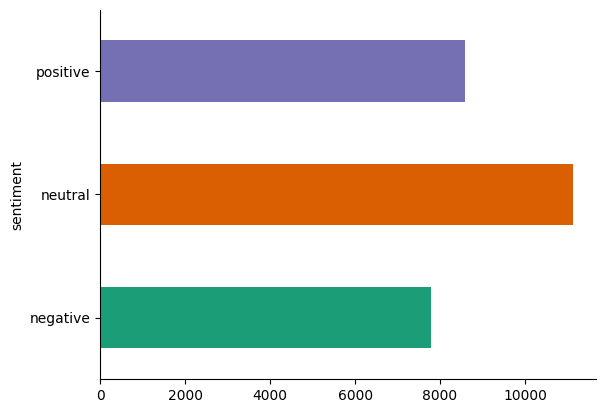

In [99]:
from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [100]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [101]:
train_df.isnull().sum()

,0
text,1
sentiment,0


In [102]:
# Handle missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

In [103]:
# Get distinct sentiment labels from both datasets
train_sentiments = train_df['sentiment'].unique().tolist()
test_sentiments = test_df['sentiment'].unique().tolist()
all_sentiments = list(set(train_sentiments + test_sentiments))

print("\nSentiment categories detected:", all_sentiments)

# Create a mapping from sentiment to numeric label
label_mapping = dict(zip(all_sentiments, range(len(all_sentiments))))

# Apply the mapping to create a new column
train_df.loc[:, 'label'] = train_df['sentiment'].apply(lambda x: label_mapping[x])
test_df.loc[:, 'label'] = test_df['sentiment'].apply(lambda x: label_mapping[x])



Sentiment categories detected: ['positive', 'neutral', 'negative']


<ipython-input-103-eda17bdab9d3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'label'] = train_df['sentiment'].apply(lambda x: label_mapping[x])


In [104]:
from sklearn.model_selection import train_test_split

# Split the training dataset into train and validation sets
train_subset, val_subset = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

print("\nDataset shapes after splitting:")
for name, df in zip(['Train', 'Validation', 'Test'], [train_subset, val_subset, test_df]):
    print(f"{name} set shape: {df.shape}")

# Display label distributions
print("\nLabel distribution per set:")
for name, df in zip(['Train', 'Validation', 'Test'], [train_subset, val_subset, test_df]):
    print(f"\n{name} set:")
    print(df['label'].value_counts())



Dataset shapes after splitting:
Train set shape: (21984, 3)
Validation set shape: (5496, 3)
Test set shape: (3534, 3)

Label distribution per set:

Train set:
label
1    8894
0    6865
2    6225
Name: count, dtype: int64

Validation set:
label
1    2223
0    1717
2    1556
Name: count, dtype: int64

Test set:
label
1    1430
0    1103
2    1001
Name: count, dtype: int64


In [84]:
from torch.utils.data import Dataset
import torch

class CustomSentimentData(Dataset):
    def __init__(self, input_texts, target_labels, tokenizer_fn, max_len=128):
        self.samples = input_texts
        self.targets = target_labels
        self.tokenizer = tokenizer_fn
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample_text = str(self.samples[index])
        sample_label = self.targets[index]

        # Perform tokenization
        tokens = self.tokenizer(
            sample_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        result = {
            'input_ids': tokens.get('input_ids').squeeze(0),
            'attention_mask': tokens.get('attention_mask').squeeze(0),
            'label': torch.LongTensor([sample_label]).squeeze()
        }

        return result


In [105]:
from transformers import AutoTokenizer

pretrained_model = "bert-base-uncased"
tokenizer_fn = AutoTokenizer.from_pretrained(pretrained_model)

# Instantiate datasets using the custom class
train_data = CustomSentimentData(
    input_texts=train_subset['text'].values,
    target_labels=train_subset['label'].values,
    tokenizer_fn=tokenizer_fn
)

val_data = CustomSentimentData(
    input_texts=val_subset['text'].values,
    target_labels=val_subset['label'].values,
    tokenizer_fn=tokenizer_fn
)

test_data = CustomSentimentData(
    input_texts=test_df['text'].values,
    target_labels=test_df['label'].values,
    tokenizer_fn=tokenizer_fn
)

# Display sizes of the datasets
print("Dataset lengths:")
print(" - Train:", len(train_data))
print(" - Validation:", len(val_data))
print(" - Test:", len(test_data))


Dataset lengths:
 - Train: 21984
 - Validation: 5496
 - Test: 3534


In [113]:
from torch.utils.data import DataLoader

BATCH_SIZE = 126

# Helper function for creating data loaders
def get_loader(dataset, shuffle=False):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True,
        drop_last=False
    )

# Initialize data loaders
train_loader = get_loader(train_data, shuffle=True)
val_loader = get_loader(val_data)
test_loader = get_loader(test_data)

# Display loader info
print("\nDataLoader Configuration:")
print(f" - Training batches: {len(train_loader)} (Batch size: {BATCH_SIZE})")
print(f" - Validation batches: {len(val_loader)}")
print(f" - Testing batches: {len(test_loader)}")



DataLoader Configuration:
 - Training batches: 175 (Batch size: 126)
 - Validation batches: 44
 - Testing batches: 29


In [87]:
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup

# Load the pre-trained model for classification
classification_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model,
    num_labels=len(label_mapping),
    problem_type="single_label_classification"
)
classification_model.to(device)

print(f"\nInitialized model '{pretrained_model}' with {classification_model.num_labels} target classes.")

# Define training hyperparameters
NUM_EPOCHS = 5
LR = 3e-5
DECAY = 1e-2

# Setup the optimizer
optimizer = torch.optim.AdamW(
    classification_model.parameters(),
    lr=LR,
    weight_decay=DECAY
)

# Learning rate scheduler configuration
training_steps = len(train_loader) * NUM_EPOCHS
warmup_pct = 0.1
warmup_steps = int(training_steps * warmup_pct)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=training_steps
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Initialized model 'bert-base-uncased' with 3 target classes.


In [88]:
import torch

# Check if CUDA (GPU) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
classification_model.to(device)

print(f"\nInitialized model '{pretrained_model}' with {classification_model.num_labels} target classes, using {device}.")



Initialized model 'bert-base-uncased' with 3 target classes, using cuda.


In [89]:
# Reverse the sentiment mapping and create label names
label_reverse_map = {value: key for key, value in label_mapping.items()}
labels_list = [label_reverse_map.get(i, f"Unknown Class {i}") for i in range(len(label_mapping))]

# Initialize history tracker
history = {
    'train_loss': [],
    'val_loss': [],
    'test_loss': [],
    'val_accuracy': [],
    'test_accuracy': [],
    'val_precision': {label: [] for label in labels_list},
    'val_recall': {label: [] for label in labels_list},
    'val_f1': {label: [] for label in labels_list}
}

# Add GPU memory monitoring
if torch.cuda.is_available():
    history['gpu_memory_usage'] = []

# Start of the training loop
print("Training process initiated...")
print(f"Total number of labels: {len(label_mapping)}")
print(f"Label mapping overview: {label_mapping}")
print(f"Label names: {labels_list}")


Training process initiated...
Total number of labels: 3
Label mapping overview: {'positive': 0, 'neutral': 1, 'negative': 2}
Label names: ['positive', 'neutral', 'negative']


In [90]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def train_one_epoch(model, train_loader, optimizer, scheduler, device):
    """Performs training for a single epoch"""
    model.train()  # Set model to training mode
    total_loss = 0.0
    print_interval = max(1, len(train_loader) // 5)  # Update progress every 20%

    for step, data in enumerate(train_loader):
        # Prepare batch data and move to device
        inputs = {
            'input_ids': data['input_ids'].to(device),
            'attention_mask': data['attention_mask'].to(device),
            'labels': data['label'].to(device)
        }

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        model_outputs = model(**inputs)
        loss = model_outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()

        # Apply gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer and scheduler step
        optimizer.step()
        scheduler.step()

        # Periodic progress update
        if (step + 1) % print_interval == 0:
            print(f"Step {step+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss

def evaluate_model(model, data_loader, device):
    """Evaluate model performance on a given dataset"""
    model.eval()  # Set model to evaluation mode
    total_eval_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for batch in data_loader:
            # Transfer batch data to device
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }

            # Forward pass
            model_outputs = model(**inputs)
            eval_loss = model_outputs.loss
            total_eval_loss += eval_loss.item()

            # Get predicted labels
            logits = model_outputs.logits
            predicted_class = torch.argmax(logits, dim=1)

            true_labels.extend(batch['label'].cpu().numpy())
            predicted_labels.extend(predicted_class.cpu().numpy())

    avg_loss = total_eval_loss / len(data_loader)

    # Compute accuracy and other classification metrics
    accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))

    # Precision, recall, and F1 scores per class
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0
    )

    return avg_loss, accuracy, precision, recall, f1, true_labels, predicted_labels


In [91]:
epochs=5
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 50)

    # Train one epoch
    train_loss = train_one_epoch(classification_model, train_loader, optimizer, lr_scheduler, device)
    history['train_loss'].append(train_loss)

    # Monitor GPU memory if available
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated(0) / 1e9  # in GB
        history['gpu_memory_usage'].append(memory_allocated)
        print(f"GPU Memory Usage: {memory_allocated:.2f} GB")

    # Evaluate on validation set
    val_loss, val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate_model(classification_model, val_loader, device)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    # Evaluate on test set
    test_loss, test_accuracy, _, _, _, _, _ = evaluate_model(classification_model, test_loader, device)
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(test_accuracy)

    # Store precision and recall for each class
    for i, label in enumerate(labels_list):
        if i < len(val_precision):
            history['val_precision'][label].append(val_precision[i])
            history['val_recall'][label].append(val_recall[i])
            history['val_f1'][label].append(val_f1[i])

    # Print epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    # Print per-class metrics
    print("\nPer-class Validation Metrics:")
    print("-" * 50)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)
    for i, label in enumerate(labels_list):
        if i < len(val_precision):
            print(f"{label:<15} {val_precision[i]:.4f}{' ':6} {val_recall[i]:.4f}{' ':6} {val_f1[i]:.4f}")
    print("-" * 50)



Epoch 1/5
--------------------------------------------------
Step 35/175 | Loss: 1.0709
Step 70/175 | Loss: 0.9869
Step 105/175 | Loss: 0.9214
Step 140/175 | Loss: 0.6146
Step 175/175 | Loss: 0.6191
GPU Memory Usage: 1.85 GB
Training Loss: 0.8439
Validation Loss: 0.5740 | Validation Accuracy: 0.7700
Test Loss: 0.5903 | Test Accuracy: 0.7637

Per-class Validation Metrics:
--------------------------------------------------
Class           Precision  Recall     F1-Score  
--------------------------------------------------
positive        0.8689       0.7528       0.8067
neutral         0.7101       0.7778       0.7424
negative        0.7667       0.7786       0.7726
--------------------------------------------------

Epoch 2/5
--------------------------------------------------
Step 35/175 | Loss: 0.4120
Step 70/175 | Loss: 0.6897
Step 105/175 | Loss: 0.3848
Step 140/175 | Loss: 0.3229
Step 175/175 | Loss: 0.5630
GPU Memory Usage: 1.85 GB
Training Loss: 0.5082
Validation Loss: 0.5683 | Va

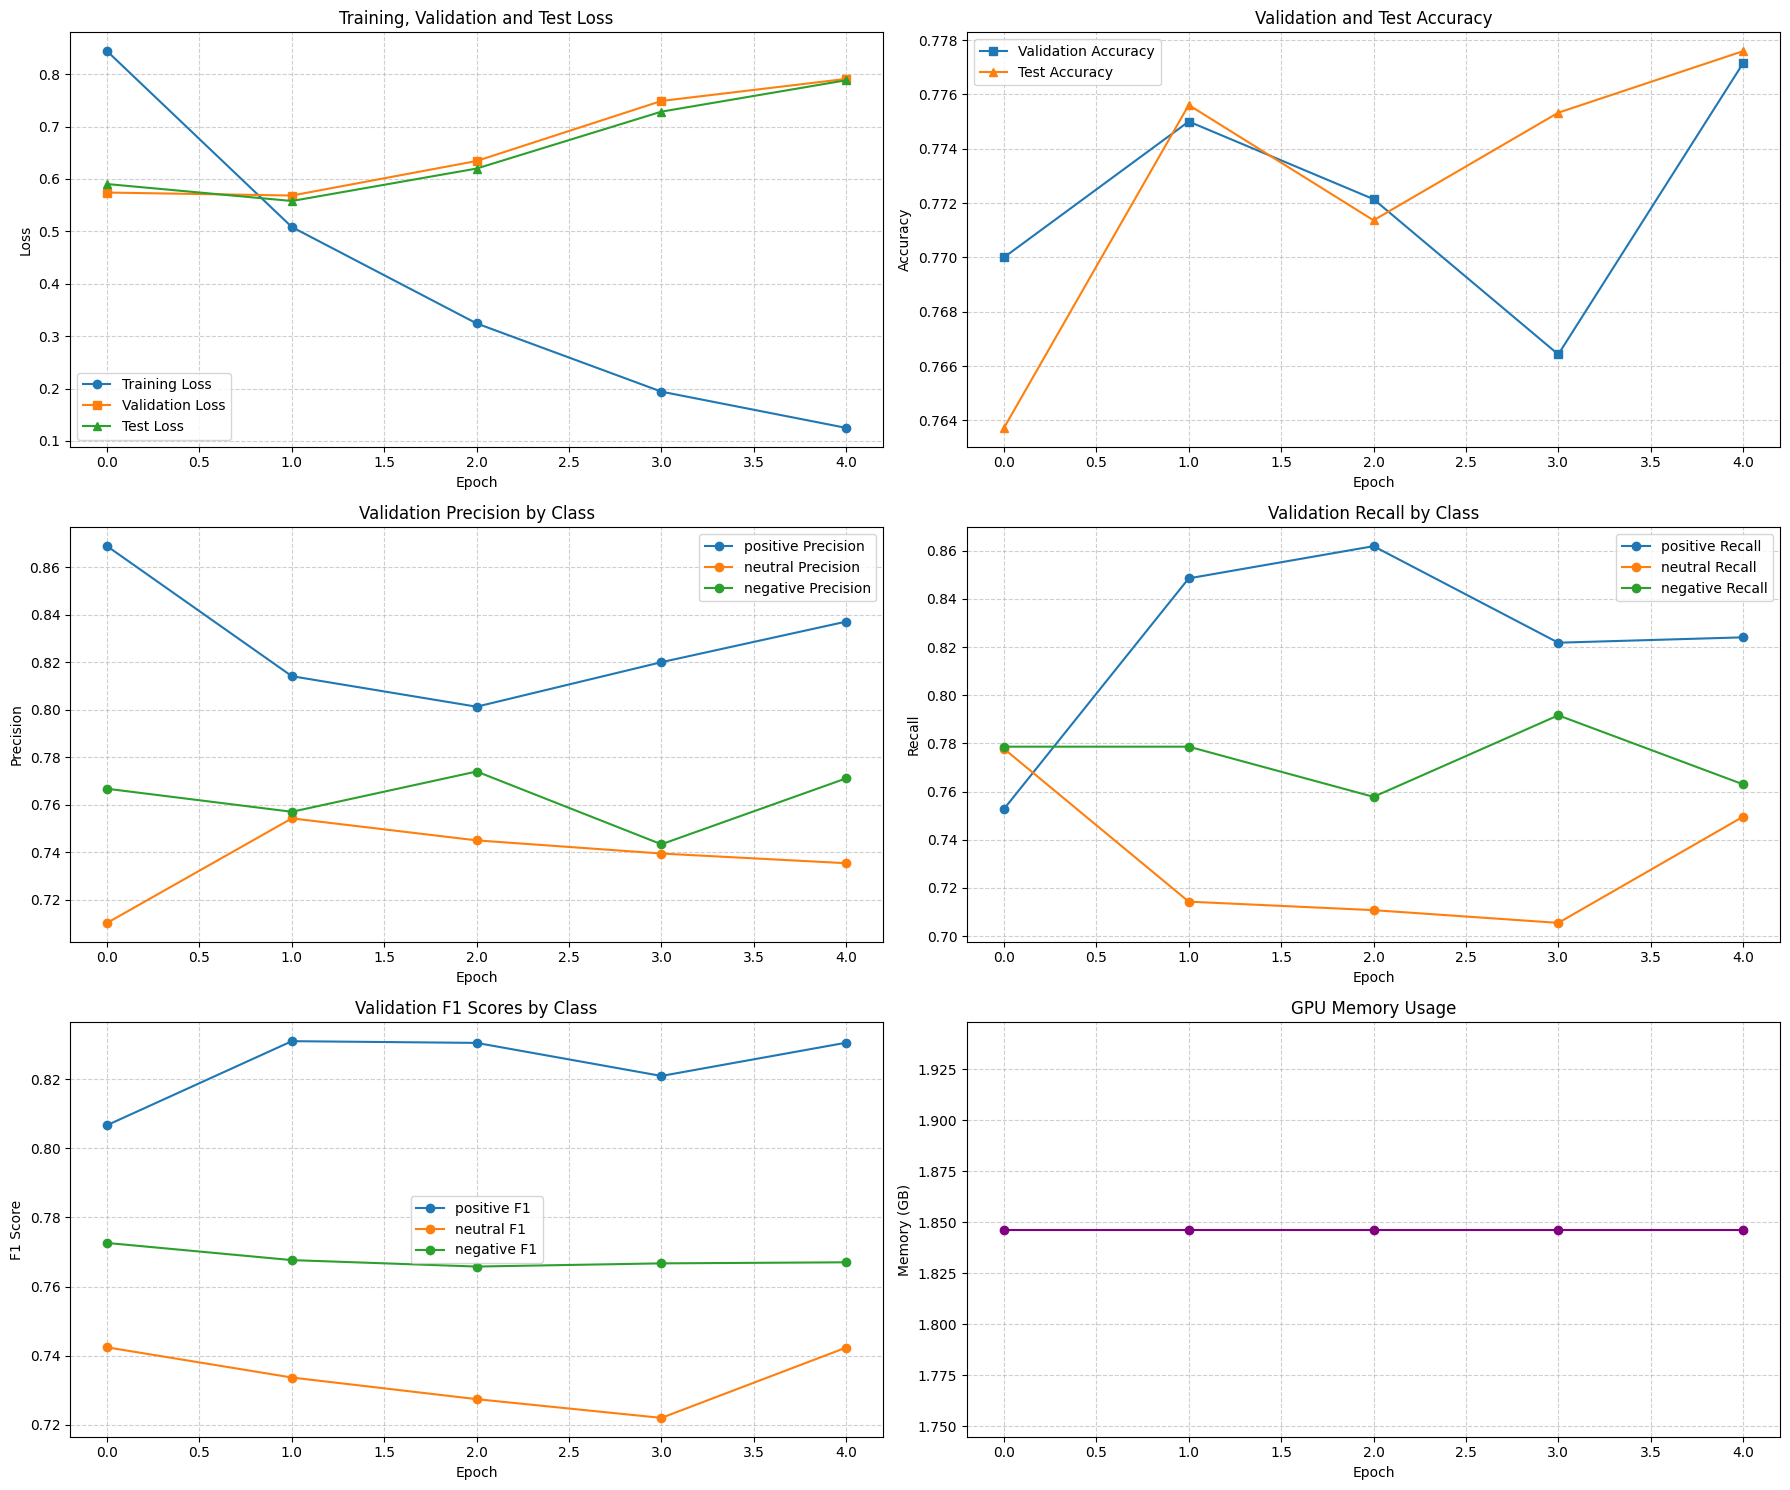

In [92]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(18, 15))

# Plot loss curves
plt.subplot(3, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.plot(history['test_loss'], label='Test Loss', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot accuracy curve
plt.subplot(3, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.plot(history['test_accuracy'], label='Test Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot precision for each class
plt.subplot(3, 2, 3)
for label in labels_list:  # Use labels_list instead of labels_list
    if label in history['val_precision'] and history['val_precision'][label]:  # Check if data exists
        plt.plot(history['val_precision'][label], label=f'{label} Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Validation Precision by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot recall for each class
plt.subplot(3, 2, 4)
for label in labels_list:  # Use labels_list instead of labels_list
    if label in history['val_recall'] and history['val_recall'][label]:  # Check if data exists
        plt.plot(history['val_recall'][label], label=f'{label} Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot F1 scores for each class
plt.subplot(3, 2, 5)
for label in labels_list:  # Use labels_list instead of labels_list
    if label in history['val_f1'] and history['val_f1'][label]:  # Check if data exists
        plt.plot(history['val_f1'][label], label=f'{label} F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Scores by Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot GPU memory usage if available
if torch.cuda.is_available() and 'gpu_memory_usage' in history:
    plt.subplot(3, 2, 6)
    plt.plot(history['gpu_memory_usage'], label='GPU Memory', marker='o', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Memory (GB)')
    plt.title('GPU Memory Usage')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('training_metrics_gpu.png')  # Save the plots
plt.show()


Final Classification Report on Test Set:
              precision    recall  f1-score   support

    positive       0.82      0.82      0.82      1103
     neutral       0.74      0.74      0.74      1430
    negative       0.78      0.79      0.78      1001

    accuracy                           0.78      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.78      0.78      0.78      3534


Final Per-class Test Metrics:
--------------------------------------------------
Class           Precision  Recall     F1-Score  
--------------------------------------------------
positive        0.8193       0.8223       0.8208
neutral         0.7445       0.7378       0.7411
negative        0.7782       0.7852       0.7817
--------------------------------------------------


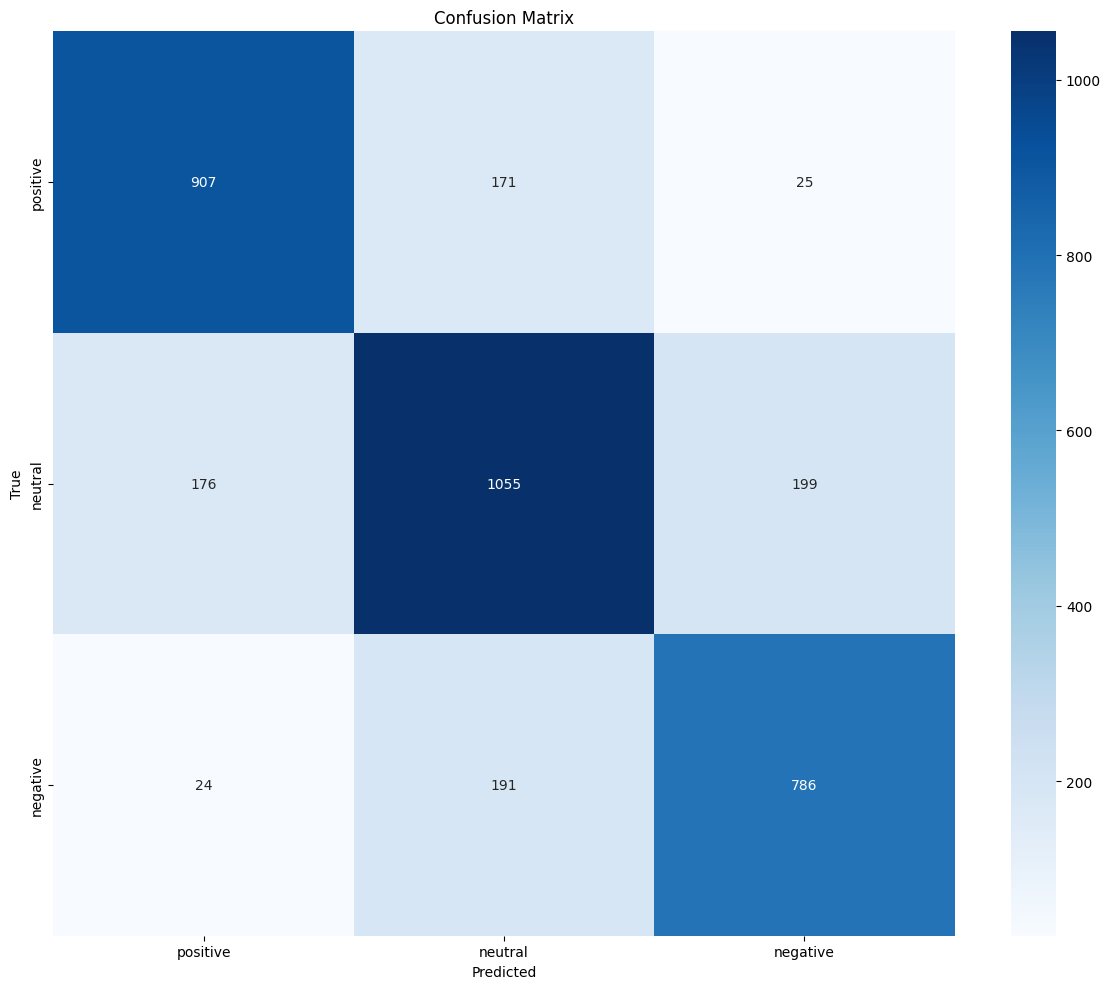

In [93]:
classification_model.eval()
_, _, test_precision, test_recall, test_f1, all_labels, all_predictions = evaluate_model(classification_model, test_loader, device)

# Classification report
print("Final Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=labels_list))

# Print final per-class metrics
print("\nFinal Per-class Test Metrics:")
print("-" * 50)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 50)
for i, label in enumerate(labels_list):
    if i < len(test_precision):
        print(f"{label:<15} {test_precision[i]:.4f}{' ':6} {test_recall[i]:.4f}{' ':6} {test_f1[i]:.4f}")
print("-" * 50)

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_list,
            yticklabels=labels_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_gpu.png')  # Save the confusion matrix
plt.show()